# Jupyter Notebook Demo mit FIR Filter


In [5]:
import numpy as np
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show

array([10.5, 11. , 11.5, 12. , 12.5])

## Some Filter stuff

FIR Filter example from:  
https://scipy-cookbook.readthedocs.io/items/FIRFilter.html  

slightly modified

In [21]:
#------------------------------------------------
# Create a signal for demonstration.
#------------------------------------------------

sample_rate = 100.0
nsamples = 400
t = np.arange(nsamples) / sample_rate
x = 1.0*np.cos(2*pi* 0.5*t + 0.0) + 0.2*np.sin(2*pi* 2.5*t+0.1) + \
    0.2*np.sin(2*pi*15.3*t + 0.0) + 0.1*np.sin(2*pi*16.7*t+0.1) + \
    0.1*np.sin(2*pi*23.45*t+ 0.8)

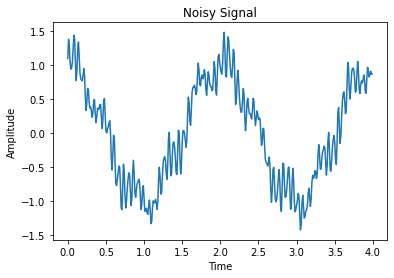

In [26]:
plot(t,x)
xlabel('Time')
ylabel('Amplitude')
title('Noisy Signal');

In [27]:
#------------------------------------------------
# Create a FIR filter and apply it to x.
#------------------------------------------------

# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 10.0

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))


In [ ]:
#------------------------------------------------
# Plot the FIR filter coefficients.
#------------------------------------------------

figure(1)
plot(taps, 'bo-', linewidth=2)
title('Filter Coefficients (%d taps)' % N)
grid(True)

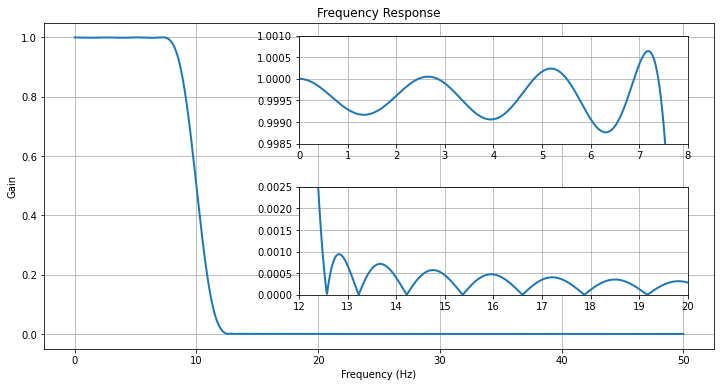

In [12]:
#------------------------------------------------
# Plot the magnitude response of the filter.
#------------------------------------------------

figure(2, figsize=(12,6))
clf()
w, h = freqz(taps, worN=8000)
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlabel('Frequency (Hz)')
ylabel('Gain')
title('Frequency Response')
ylim(-0.05, 1.05)
grid(True)

# Upper inset plot.
ax1 = axes([0.42, 0.6, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(0,8.0)
ylim(0.9985, 1.001)
grid(True)

# Lower inset plot
ax2 = axes([0.42, 0.25, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(12.0, 20.0)
ylim(0.0, 0.0025)
grid(True)


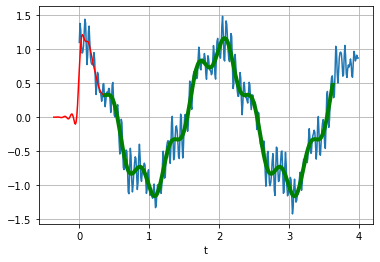

In [29]:
#------------------------------------------------
# Plot the original and filtered signals.
#------------------------------------------------

# Use lfilter to filter x with the FIR filter.
filtered_x = lfilter(taps, 1.0, x)

# The phase delay of the filtered signal.
delay = 0.5 * (N-1) / sample_rate

figure(3)
# Plot the original signal.
plot(t, x)
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t-delay, filtered_x, 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[N-1:]-delay, filtered_x[N-1:], 'g', linewidth=4)

xlabel('t')
grid(True)

## Going from Filter Design to FPGA Implementation

you could pipe your filter coefficients from python desing to your favorite FPGA Design Tool.  

Example for Xilinx FIR Compiler
https://docs.xilinx.com/v/u/en-US/pg149-fir-compiler

Coe-file:  
```
radix=coefficient_radix;
coefdata=
a(0),
a(1),
a(2),
....
a(N-1);
```



In [32]:
taps[1:5]

array([-8.36125348e-05,  1.19173505e-04,  4.25496657e-04,  6.94633526e-04])

In [43]:
# --------------------------------------
# print taps to coef file
# --------------------------------------
num_taps=len(taps)

with open('my_fir_taps.coef', 'w') as fd:
    print("radix=10", file=fd)
    print("coefdata=", file=fd)
    for ii in range(L):
        print("%.32f," % taps[ii], file=fd)

will print to file:
```
radix=10
coefdata=
-0.00014378422293726239155481350096,
-0.00008361253479320474122239020831,
0.00011917350457213215586885213249,
...
0.00042549665693391501520778663625
```

! ! !
Be aware that this is floating point stuff. VHDL is fundamentally a fixed point language. 
Filter Compiler migth do some quantization. 
  
Just a basic example!

However, design filter...pipe coefs to syntheses tool...click run..drink coffee. Done in 5 minutes (if you type slowly, otherwise it will be 3 minutes) :-)